# Setup

In [11]:
# Checks if the code is in a colab notebook

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_LR_clean.zip
    IN_COLAB = True
except:
    IN_COLAB = False

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import cv2
import csv
import numpy as np
import os
#from basicsr.archs.rrdbnet_arch import RRDBNet as RRDBNetOriginal
import torchvision
from os import listdir, environ, path
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19
import pandas as pd
import ipywidgets as widgets
import math
#from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip

# Making sure to use the gpu, if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

In [ ]:
w = widgets.FileUpload(
    #accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

In [3]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.L1Loss()
        self.vgg = vgg19(weights='DEFAULT').features[:35].eval().to(DEVICE)
        
        for param in self.vgg.parameters():
            param.requires_grad = False
    
    def forward(self, X, y):
        vgg_input_features = self.vgg(X)
        vgg_target_features = self.vgg(y)
        return self.loss(vgg_input_features, vgg_target_features)
    
    
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.activation = nn.LeakyReLU(.2, inplace=True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class RDB(nn.Module):
  def __init__(self, in_channels, middle_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.block = nn.ModuleList([ConvBlock(in_channels + i * middle_channels,
                                  middle_channels if i<4 else in_channels,
                                  3,
                                  stride=1,
                                  padding=1,
                                  use_act=i<4) for i in range(5)])


  def forward(self, x):
    input = x
    for conv in self.block:
      out = conv(input)
      input = torch.cat([input, out], dim=1)
    return self.residual_scale * out + x

class RRDB(nn.Module):
  def __init__(self, in_channels, mid_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.model = nn.Sequential(*[RDB(in_channels, middle_channels = mid_channels, residual_scale = residual_scale) for _ in range(3)])
  
  def forward(self, x):
    return self.model(x) * self.residual_scale + x

class Head(nn.Module):
  def __init__(self, out_channels = 64) -> None:
    super().__init__()
    self.model = nn.Conv2d(3, out_channels, 3, stride=1, padding=1)

  def forward(self, x):
    return self.model(x)

class Tail(nn.Module):
  def __init__(self, in_channels = 64) -> None:
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
                               nn.Upsample(scale_factor=4, mode='nearest'),
                               nn.LeakyReLU(.2, inplace=True),
                               nn.Conv2d(256, 3, 3, stride=1, padding=1))
  
  def forward(self, x):
    return self.model(x)

# Original code for ESRGAN:
# https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers, **kwargs):
    layers = []
    for _ in range(n_layers):
        layers.append(block(**kwargs))
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=23, gc=32):
        super(RRDBNet, self).__init__()

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB, nb, nf=nf, gc=gc)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(feat))
        feat = feat + trunk

        feat = self.lrelu(self.upconv1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.upconv2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(feat)))

        return out

In [4]:
def tile_process(model: nn.Module, img: torch.Tensor):
    """It will first crop input images to tiles, and then process each tile.
    Finally, all the processed tiles are merged into one images.
    Modified from: https://github.com/ata4/esrgan-launcher
    """
    TILE_SIZE = 450
    TILE_PAD = 10

    channel, height, width = img.shape
    output_height = height * 4
    output_width = width * 4
    output_shape = (channel, output_height, output_width)

    # start with black image
    output = img.new_zeros(output_shape)
    tiles_x = math.ceil(width / TILE_SIZE)
    tiles_y = math.ceil(height / TILE_SIZE)

    # loop over all tiles
    for y in range(tiles_y):
        for x in range(tiles_x):
            # extract tile from input image
            ofs_x = x * TILE_SIZE
            ofs_y = y * TILE_SIZE
            # input tile area on total image
            input_start_x = ofs_x
            input_end_x = min(ofs_x + TILE_SIZE, width)
            input_start_y = ofs_y
            input_end_y = min(ofs_y + TILE_SIZE, height)

            # input tile area on total image with padding
            input_start_x_pad = max(input_start_x - TILE_PAD, 0)
            input_end_x_pad = min(input_end_x + TILE_PAD, width)
            input_start_y_pad = max(input_start_y - TILE_PAD, 0)
            input_end_y_pad = min(input_end_y + TILE_PAD, height)

            # input tile dimensions
            input_tile_width = input_end_x - input_start_x
            input_tile_height = input_end_y - input_start_y
            tile_idx = y * tiles_x + x + 1
            input_tile = img[:, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

            # upscale tile
            try:
                with torch.no_grad():
                    output_tile = model(input_tile.unsqueeze(dim=0).to(DEVICE))[0]
            except RuntimeError as error:
                print('Error', error)
            print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

            # output tile area on total image
            output_start_x = input_start_x * 4
            output_end_x = input_end_x * 4
            output_start_y = input_start_y * 4
            output_end_y = input_end_y * 4

            # output tile area without padding
            output_start_x_tile = (input_start_x - input_start_x_pad) * 4
            output_end_x_tile = output_start_x_tile + input_tile_width * 4
            output_start_y_tile = (input_start_y - input_start_y_pad) * 4
            output_end_y_tile = output_start_y_tile + input_tile_height * 4

            # put tile into output image
            output[:, output_start_y:output_end_y,
                        output_start_x:output_end_x] = output_tile[:, output_start_y_tile:output_end_y_tile,
                                                                   output_start_x_tile:output_end_x_tile]
    return output.clamp_(0.,1.)



def enhance(model: nn.Module, img: Image) -> Image:
    image_tensor = torchvision.transforms.ToTensor()(img)
    
    model.to(DEVICE)
    model.eval()
    
    return torchvision.transforms.ToPILImage()(tile_process(model, image_tensor))

def get_ratio(width, height, max_side):
    side = max(width, height)
    return max_side/side

def enhance_video(model: nn.Module, in_file: str, out_file: str, keep_size: bool = False, end_frame: int = -1, max_size = 450):
    vidcap = cv2.VideoCapture(in_file)
    framerate = vidcap.get(cv2.CAP_PROP_FPS)
    nb_of_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    success, image = vidcap.read()

    shape = image.shape
    
    if keep_size:
        # Input shape
        shape = (int(shape[1] // 4), int(shape[0] // 4))
        IS_LARGE = max_size > 0 and max(*shape) > max_size
        if IS_LARGE:
            ratio = get_ratio(shape[0], shape[1], max_size)
            shape = (int(shape[0] * ratio), int(shape[1] * ratio))
        # Output shape
        shape = (shape[0] * 4, shape[1] * 4)
    else:
        # Input shape
        shape = (shape[1], shape[0])
        IS_LARGE = max_size > 0 and max(*shape) > max_size
        if IS_LARGE:
            ratio = get_ratio(shape[0], shape[1], max_size)
            shape = (int(shape[0] * ratio), int(shape[1] * ratio))
        # Output shape
        shape = (shape[0] * 4, shape[1] * 4)
    
    # shape is (width, height)
    # the image shape given by the shape attribute
    # is (height, width, channels)
    out = cv2.VideoWriter(out_file, fourcc, framerate, shape)
    count = 0

    while success and (end_frame < 0 or count < end_frame):
        print(f'\nImage {count}/{nb_of_frames}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if keep_size or IS_LARGE:
            image = image.resize((shape[0] // 4, shape[1] // 4))

        if isinstance(model, nn.Module):
            output = enhance(model, image)
        elif isinstance(model, int):
            output = image.resize(shape, model)

        output = np.array(output)
        output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
        out.write(output)

        success, image = vidcap.read()
        count += 1

    vidcap.release()
    out.release()
    cv2.destroyAllWindows()
    return vidcap, out

def resize_ratio(img, size=48):
  width, height = img.size
  if width > height:
    width, height = size, int(height * size / width)
  else:
    width, height = int(width * size / height), size
  return width, height

# Handling images

In [40]:
if IN_COLAB:
    filename = 'DIV2K_valid_LR_clean/0850.png'
    OUTPUT_FOLDER = 'out/'
    # for videos only
    # tmp_filename = OUTPUT_FOLDER + 'tmp.avi'
    out_filename = OUTPUT_FOLDER + '0850.png'
    # for larger images
    model_path = f'drive/MyDrive/ML/Indiv_Project/Second_Year/ESRGAN_Scratch/model_ASSIGNMENT.pth'
    # for smaller images
    #model_path = f'drive/MyDrive/ML/Indiv_Project/Second_Year/ESRGAN_Scratch/model_L1_0_29.pth'
else:
    filename = 'C:\\Users\Vincent\Downloads\\piano.mp4'
    OUTPUT_FOLDER = 'C:\\Users\Vincent\Downloads\\'
    tmp_filename = OUTPUT_FOLDER + 'tmp.avi'
    out_filename = OUTPUT_FOLDER + 'output.avi'
    model_path = f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\model.pth'

In [42]:
model = RRDBNet()
saved_info = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(saved_info['model_state_dict'])
model.to(DEVICE)

#esrgan = RRDBNetOriginal(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
#saved_info = torch.load('D:\oldDrive\ML\Indiv_Project\Second_Year\KD\ESRGAN_models\RealESRGAN_x4plus.pth', map_location=torch.device('cpu'))
#esrgan.load_state_dict(saved_info['params_ema'])
#esrgan.to(DEVICE)

RRDBNet(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (RRDB_trunk): Sequential(
    (0): RRDB(
      (RDB1): ResidualDenseBlock_5C(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (RDB2): ResidualDenseBlock_5C(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), str

	Tile 1/1


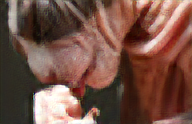

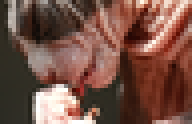

In [54]:
img_name = 'DIV2K_valid_LR_clean/0838.png'
img = Image.open(img_name)
width, height = img.size
width, height = resize_ratio(img, 48)
img = img.resize((width, height), 1)
out = enhance(model, img)
display(out)
display(img.resize((width*4, height*4), 0))

In [ ]:
vidcap, out = enhance_video(model, filename, tmp_filename, end_frame=30*15, max_size = 1920//4)


Image 0/5135
	Tile 1/2
	Tile 2/2

Image 1/5135
	Tile 1/2
	Tile 2/2

Image 2/5135
	Tile 1/2
	Tile 2/2

Image 3/5135
	Tile 1/2
	Tile 2/2

Image 4/5135
	Tile 1/2
	Tile 2/2

Image 5/5135
	Tile 1/2
	Tile 2/2

Image 6/5135
	Tile 1/2
	Tile 2/2

Image 7/5135
	Tile 1/2
	Tile 2/2

Image 8/5135
	Tile 1/2
	Tile 2/2

Image 9/5135
	Tile 1/2
	Tile 2/2

Image 10/5135
	Tile 1/2
	Tile 2/2

Image 11/5135
	Tile 1/2
	Tile 2/2

Image 12/5135
	Tile 1/2
	Tile 2/2

Image 13/5135
	Tile 1/2
	Tile 2/2

Image 14/5135
	Tile 1/2
	Tile 2/2

Image 15/5135
	Tile 1/2
	Tile 2/2

Image 16/5135
	Tile 1/2
	Tile 2/2

Image 17/5135
	Tile 1/2
	Tile 2/2

Image 18/5135
	Tile 1/2
	Tile 2/2

Image 19/5135
	Tile 1/2
	Tile 2/2

Image 20/5135
	Tile 1/2
	Tile 2/2

Image 21/5135
	Tile 1/2
	Tile 2/2

Image 22/5135
	Tile 1/2
	Tile 2/2

Image 23/5135
	Tile 1/2
	Tile 2/2

Image 24/5135
	Tile 1/2
	Tile 2/2

Image 25/5135
	Tile 1/2
	Tile 2/2

Image 26/5135
	Tile 1/2
	Tile 2/2

Image 27/5135
	Tile 1/2
	Tile 2/2

Image 28/5135
	Tile 1/2
	Tile

	Tile 2/2

Image 231/5135
	Tile 1/2
	Tile 2/2

Image 232/5135
	Tile 1/2
	Tile 2/2

Image 233/5135
	Tile 1/2
	Tile 2/2

Image 234/5135
	Tile 1/2
	Tile 2/2

Image 235/5135
	Tile 1/2
	Tile 2/2

Image 236/5135
	Tile 1/2
	Tile 2/2

Image 237/5135
	Tile 1/2
	Tile 2/2

Image 238/5135
	Tile 1/2
	Tile 2/2

Image 239/5135
	Tile 1/2
	Tile 2/2

Image 240/5135
	Tile 1/2
	Tile 2/2

Image 241/5135
	Tile 1/2
	Tile 2/2

Image 242/5135
	Tile 1/2
	Tile 2/2

Image 243/5135
	Tile 1/2
	Tile 2/2

Image 244/5135
	Tile 1/2
	Tile 2/2

Image 245/5135
	Tile 1/2
	Tile 2/2

Image 246/5135
	Tile 1/2
	Tile 2/2

Image 247/5135
	Tile 1/2
	Tile 2/2

Image 248/5135
	Tile 1/2
	Tile 2/2

Image 249/5135
	Tile 1/2
	Tile 2/2

Image 250/5135
	Tile 1/2
	Tile 2/2

Image 251/5135
	Tile 1/2
	Tile 2/2

Image 252/5135
	Tile 1/2
	Tile 2/2

Image 253/5135
	Tile 1/2
	Tile 2/2

Image 254/5135
	Tile 1/2
	Tile 2/2

Image 255/5135
	Tile 1/2
	Tile 2/2

Image 256/5135
	Tile 1/2
	Tile 2/2

Image 257/5135
	Tile 1/2
	Tile 2/2

Image 258/5135
	T

In [ ]:
vidcap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
vidcap = cv2.VideoCapture(out_filename)
success, image = vidcap.read()
vidcap.release()
success

False

# Adding the sound

In [ ]:
video_file = tmp_filename
audio_file = filename

# load the video
video_clip = VideoFileClip(video_file)
# load the audio
audio_clip = AudioFileClip(audio_file)

final_clip = video_clip.set_audio(final_audio)
final.clip.write_videofile(out_filename)